# Modules to be Installed
The following modules are required for this project:

- `os`
- `sys`
- `gmsh`
- `numpy` (`np`)
- `pandas` (`pd`)
- `pyvista` (`pv`)
- `matplotlib.pyplot` (`plt`)
- `math`
- `meshio`
- `gmshparser`
- `importlib`
-  `math`
- `shapely.geometry`
```markdown
To install these modules, use the following pip command:

```bash
pip install os sys gmsh numpy pandas pyvista matplotlib math meshio gmshparser importlib

```

In [366]:
# appel fonction mesh
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 18 14:57:23 2023
import functions mesh
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
# Ajouter le chemin du dossier src au PYTHONPATH
import importlib
sys.path.append('/home/ariviere/Programmes/ginette')  # Ajouter le dossier parent de src
from src.src_gmsh import mesh_generator
from src.src_python import Init_folders
from src.src_python import Read_obs
from src.src_python import Direct_model
importlib.reload(mesh_generator)
from src.src_gmsh.mesh_generator import *
from src.src_python.Init_folders import *
from src.src_python.Direct_model import *
from src.src_python.Read_obs import *
#print functions of Init_folders


importlib.reload(Init_folders)
importlib.reload(Read_obs)
importlib.reload(mesh_generator)
# give me all names of the functions in Init_folders
#print(Init_folders.__dict__)
#print([name for name in dir(Init_folders) if callable(getattr(Init_folders, name)) and not name.startswith("__")])

compile_ginette()

ginette exists


In [367]:
# Configuration du répertoire de travail
# Utiliser os.getcwd() pour obtenir le répertoire de travail actuel
script_dir = os.getcwd()  # Répertoire du notebook
mesh_dir = os.path.join(script_dir, "meshdata")  # Chemin absolu vers "meshdata"
sim_dir= script_dir
file_path = "/home/ariviere/Documents/Bassin_Orgeval/Donnee_Orgeval_Mines/raw_data/DESC_data/DATA_STATION/"  # Chemin vers le fichier CSV
obs_dir=os.path.abspath(os.path.join(file_path, "../../../processed_data/"))
# Ajouter le chemin du dossier src au PYTHONPATH
sys.path.insert(0, "/home/ariviere/Programmes/ginette/src")
# Paramètres de du maillage
## name de la station
Station = "IntD"
# Paramètres sens de la station par rapport à la direction de la rivière
#       |   ↑    |
#  RG   |   ↑    |  RD
#       |        |
#  Rive_D=0 station à l'envers x_piezo_RD=0m dans l'exemple du schema
Rive_D=0
plot=True
meshplot=True
altitude_min = 103
dz_pt100=0.15
dz_pt100first=0.1



Chemin du fichier de nivellement CSV : /home/ariviere/Documents/Bassin_Orgeval/Donnee_Orgeval_Mines/raw_data/DESC_data/DATA_STATION/IntD/IntD.csv
coordonnées des capteurs de températures
    hobo  pt100  Distance (m)  Altitude (Z)
0  hobo7      1           6.8        104.50
1  hobo7      2           6.8        104.35
2  hobo7      3           6.8        104.20
3  hobo7      4           6.8        104.05
4  hobo6      1           8.7        104.50
5  hobo6      2           8.7        104.35
6  hobo6      3           8.7        104.20
7  hobo6      4           8.7        104.05


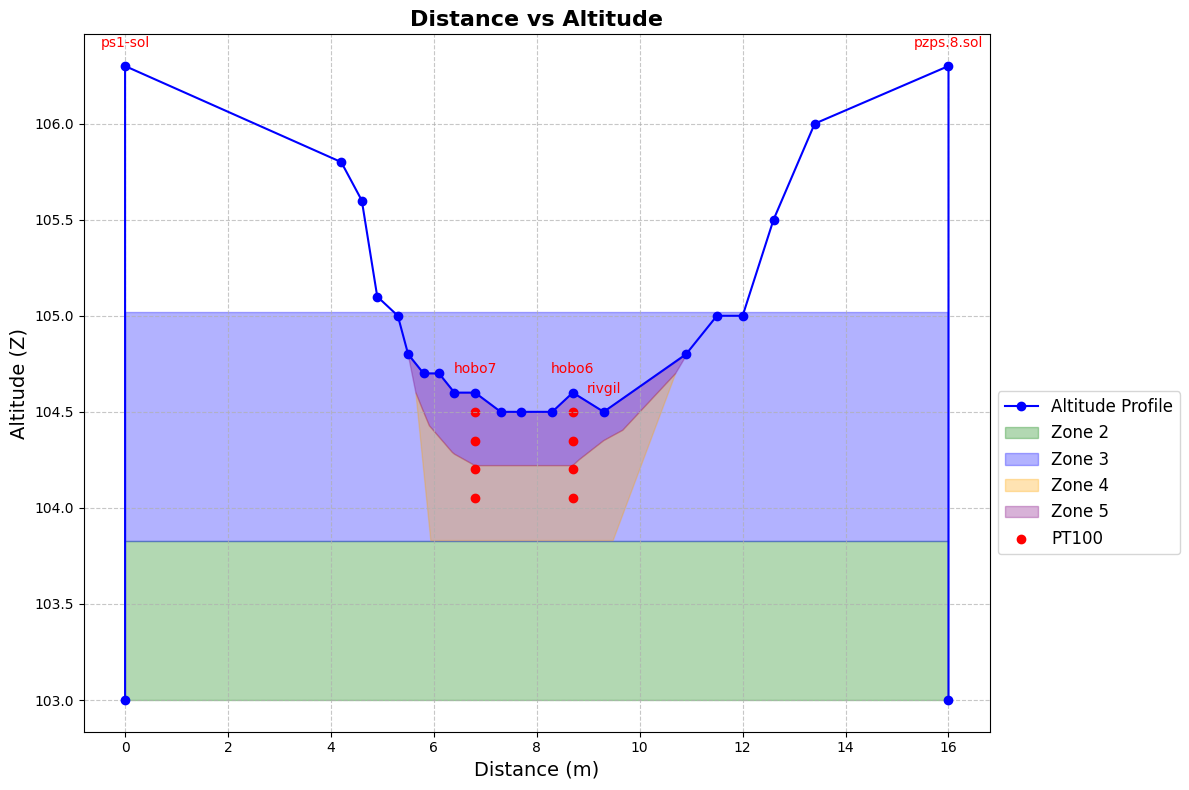

In [368]:
# reading the data georef
distance_altitude_table,pt100_coord= process_distance_altitude(file_path, Station, mesh_dir, altitude_min, Rive_D,dz_pt100=dz_pt100,dz_pt100first=dz_pt100first)    

print("coordonnées des capteurs de températures")
print(pt100_coord)
# definition des zones zones
#zone 1 
#zone 2
permeabilite_2 = 2.5662199999999999E-08 
rect_2 = np.array([[0, 103.], [16, 103.],[16., 103.83],[0, 103.83]])
# zone 3
permeabilite_3 = 9.9999999999999995E-07
rect_3= np.array([[0, 103.83], [16, 103.83],[16, 105.02],[0, 105.02]])
# zone 4
permeabilite_4=0.0001200000000000000
poly_4=np.array([[10.7,104.7],[9.67076,104.40417],[9.48341,104.37706],[9.3,104.35],
                 [8.82518,104.25082],[8.7,104.22],[8.35,104.22],[7.3,104.22],
                 [6.8,104.22],[6.4,104.28],[6.35819,104.28925],
                 [5.91353,104.42771],[5.8,104.5],[5.65,104.6],
                 [5.94139,103.83],
               [6.8832,103.83],[7.40838,103.83],[8.06661,103.83], 
                 [9.3,103.83],[9.48341,103.83]
                ])
# zone 5        
permeabilite_5=4.9899999999999997E-08 
poly_5=np.array([[10.7,104.7],[9.67076,104.40417],[9.48341,104.37706],[9.3,104.35],
                 [8.82518,104.25082],[8.7,104.22],[8.35,104.22],[7.3,104.22],
                 [6.8,104.22],[6.4,104.28],[6.35819,104.28925],
                 [5.91353,104.42771],[5.8,104.5],[5.65,104.6],[5.5,104.8],
                 [5.8,104.7],[6.1,104.7],[6.4,104.6],[6.8,104.6],
                 [7.3,104.5],[7.7,104.5],[8.3,104.5],[8.7,104.6],[9.3,104.5],[10.92239,104.8]]) 
# 
# 
#    
# plot des données
if plot:
    import matplotlib.pyplot as plt

    # Configure the plot
    plt.figure(figsize=(12, 8))
    plt.plot(
        distance_altitude_table["Distance (m)"],
        distance_altitude_table["Altitude (Z)"],
        marker='o',
        # add name distance_altitude_table["Instrument"] if not NA
        linestyle='-',
        color='blue',
        label='Altitude Profile'
    )

    # Ajouter les noms des instruments au-dessus des points si ce n'est pas "NA"
    for i, instrument in enumerate(distance_altitude_table["Instrument"]):
        if instrument != "NA" and not pd.isna(instrument):
            plt.text(
                distance_altitude_table["Distance (m)"][i],
                distance_altitude_table["Altitude (Z)"][i] + 0.1,  # Décalage vertical pour éviter de chevaucher le point
                instrument,
                fontsize=10,
                color='red',
                ha='center'
            )
    # Tracer les zones rectangulaires xmin ymin and xmax ymax

    plt.fill(rect_2[:, 0], rect_2[:, 1], color='green', alpha=0.3, label='Zone 2')
    plt.fill(rect_3[:, 0], rect_3[:, 1], color='blue', alpha=0.3, label='Zone 3')
    plt.fill(poly_4[:, 0], poly_4[:, 1], color='orange', alpha=0.3, label='Zone 4')
    plt.fill(poly_5[:, 0], poly_5[:, 1], color='purple', alpha=0.3, label='Zone 5')

# Tracer les capteurs de température PT100
# Tracer les capteurs de température PT100
    if not pt100_coord.empty:
        pt100_label_added = False  # Variable pour suivre si le label "PT100" a été ajouté
        for i in range(len(pt100_coord)):
            plt.scatter(
                pt100_coord["Distance (m)"][i],
                pt100_coord["Altitude (Z)"][i],
                color='red',
                label="PT100" if not pt100_label_added else None  # Ajouter le label uniquement une fois
            )
            pt100_label_added = True  # Marquer que le label a été ajouté
    # Add titles and labels    # Initialize the neighbors as -99 (no neighbor)
    # The neighbors are stored in the ivois DataFrame
    plt.title("Distance vs Altitude", fontsize=16, fontweight='bold')
    plt.xlabel("Distance (m)", fontsize=14)
    plt.ylabel("Altitude (Z)", fontsize=14)

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
 # Ajouter la légende en dehors de la figure, à droite
    plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.tight_layout()
    plt.show()
#     





In [369]:
import math
## altitude min du maillage
x_hoboRG=6.8
x_hoboRD=8.7
z_hoboRG=104.5
z_hoboRD=104.5
x_RG=5.25
x_RD=10.25
z_riv=104.575
v_bot=103.925
dx_precis=0.10
dx_grossier=0.25
dz_grossier=0.25
dz_precis=0.05
dx_hobo=0.05
 # Calcul des subdivisions en x pour les regions centre 2 et 5
length_x_centre = x_RD-x_RG
num_div_x_centre = max(2, math.ceil(length_x_centre / dx_precis))
max_x=distance_altitude_table['Distance (m)'].max()
min_x=distance_altitude_table['Distance (m)'].min()
max_z=distance_altitude_table['Altitude (Z)'].max()
# Calcul des subdivisions en x pour les regions de gauche 1, 4 et 7
length_x_gauche = x_RG - min_x
num_div_x_gauche = max(2, math.ceil(length_x_gauche / dx_grossier))

        # Calcul des subdivisions en x pour les regions centre 2 et 5
length_x_centre = x_RD- x_RG
num_div_x_centre = max(2, math.ceil(length_x_centre / dx_precis))
# Calcul des subdivisions en x pour les regions droite 3, 6 et 8
length_x_droite = max_x - x_RD
num_div_x_droite = max(2, math.ceil(length_x_droite / dx_grossier))

        # Calcul des subdivisions en z pour les regions haute 7 et 8
num_div_z_haut = max(2, math.ceil((max_z - z_riv) / dz_grossier))
        # Ensure the number of subdivisions is an integer by adjusting the step size
if (max_z - z_riv) % dz_grossier != 0.1:
    num_div_z_haut = max(2, round((max_z - z_riv) / dz_grossier))
        
        # Calcul des subdivisions en z pour les regions centre 4, 5 et 6
num_div_z_centre = max(2, math.ceil((z_riv - v_bot) / dz_precis))

        # Calcul des subdivisions en z pour les regions bas 1,2 et 3
num_div_z_bas = max(2, math.ceil((v_bot - altitude_min)/dz_grossier))

print(f"Subdivisions calculées :\n"
            f"  - Gauche : {num_div_x_gauche} subdivisions\n"
            f" - dx gauche : {length_x_gauche / num_div_x_gauche:.2f} m\n"
            f"  - Centre : {num_div_x_centre} subdivisions\n"
            f" - dx centre : {length_x_centre / num_div_x_centre:.2f} m\n"
            f"  - Droite : {num_div_x_droite} subdivisions\n"
            f" - dx droite : {length_x_droite / num_div_x_droite:.2f} m\n"
            f"  - Haut : {num_div_z_haut} subdivisions\n"
            f" - dz haut : {(max_z - z_riv) / num_div_z_haut:.2f} m\n"
            f"  - Centre : {num_div_z_centre} subdivisions\n"
            f" - dz centre : {(z_riv - v_bot) / num_div_z_centre:.2f} m\n"
            f"  - Bas : {num_div_z_bas} subdivisions\n"
            f" - dz bas : {(v_bot - altitude_min) / num_div_z_bas:.2f} m\n")

Subdivisions calculées :
  - Gauche : 21 subdivisions
 - dx gauche : 0.25 m
  - Centre : 50 subdivisions
 - dx centre : 0.10 m
  - Droite : 23 subdivisions
 - dx droite : 0.25 m
  - Haut : 7 subdivisions
 - dz haut : 0.25 m
  - Centre : 14 subdivisions
 - dz centre : 0.05 m
  - Bas : 4 subdivisions
 - dz bas : 0.23 m



In [370]:
if meshplot:
    # Appel de la fonction
    output_mesh_path = os.path.join(mesh_dir, "rectangular_mesh.msh")
    generate_mesh_8_region(distance_altitude_table, output_mesh_path,v_bot=v_bot,x_RG =x_RG, x_RD = x_RD,z_riv=z_riv, 
                           dx_grossier=dx_grossier, dx_precis = dx_precis,x_hobo_1 =x_hoboRG, z_hobo_1=z_hoboRG,x_hobo_2 = x_hoboRD,z_hobo_2=z_hoboRD, dx_hobo=dx_hobo, 
                           dz_grossier=dz_grossier, dz_precis=dz_precis,dz_hobo1=dz_pt100first,dz_hobo=dz_pt100,mesh_dimension=2)

    output_mesh_path = os.path.join(mesh_dir, "rectangular_mesh.msh")
    remove_elements_above_curve_all_entities(distance_altitude_table, output_mesh_path, ajout='_remove_all_entities', retirer='')
    plot_gmsh_mesh(output_mesh_path.replace(".msh", "_remove_all_entities.msh")) # Modification du nom car on applique 2 fois la fct remove elements 




Génération du maillage structuré avec Gmsh...
hobo 8.65 6.85 0.1 -59.84999999999999
Subdivisions calculées :
  - Gauche : 21 subdivisions
 - dx gauche : 0.25 m
  - Centre : 50 subdivisions
 - dx centre : 0.10 m
  - Droite : 23 subdivisions
 - dx droite : 0.25 m
  - Haut : 7 subdivisions
 - dz haut : 0.25 m
  - Centre : 14 subdivisions
 - dz centre : 0.05 m
  - Bas : 4 subdivisions
 - dz bas : 0.23 m

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info  

Widget(value='<iframe src="http://localhost:38079/index.html?ui=P_0x7c9b279f4370_14&reconnect=auto" class="pyv…

# creation fichier coordonnées

In [371]:

from src.src_gmsh import mesh_generator
importlib.reload(mesh_generator)

from src.src_gmsh.mesh_generator import readGmsh
fName = os.path.join(mesh_dir, "rectangular_mesh_remove_all_entities.msh")
# rename to pt100_coord with x and z
pt100_coord.rename(columns={"Distance (m)": "x", "Altitude (Z)": "z"}, inplace=True)

centres,nb_mesh = readGmsh(fName, precision=3)
# write the coordinates in a file witout the header
centres.to_csv(os.path.join(sim_dir, "E_coordonnee.dat"), sep=' ', header=False, index=False)


# write index with the first =1 in the first column of the centres dataframe
centres['index'] = np.arange(1, len(centres) + 1)

print(centres.head())


       x        z  index
0  0.131  106.156      1
1  0.131  105.869      2
2  0.131  105.581      3
3  0.131  105.294      4
4  0.131  105.006      5


### Figure des centres de mailles

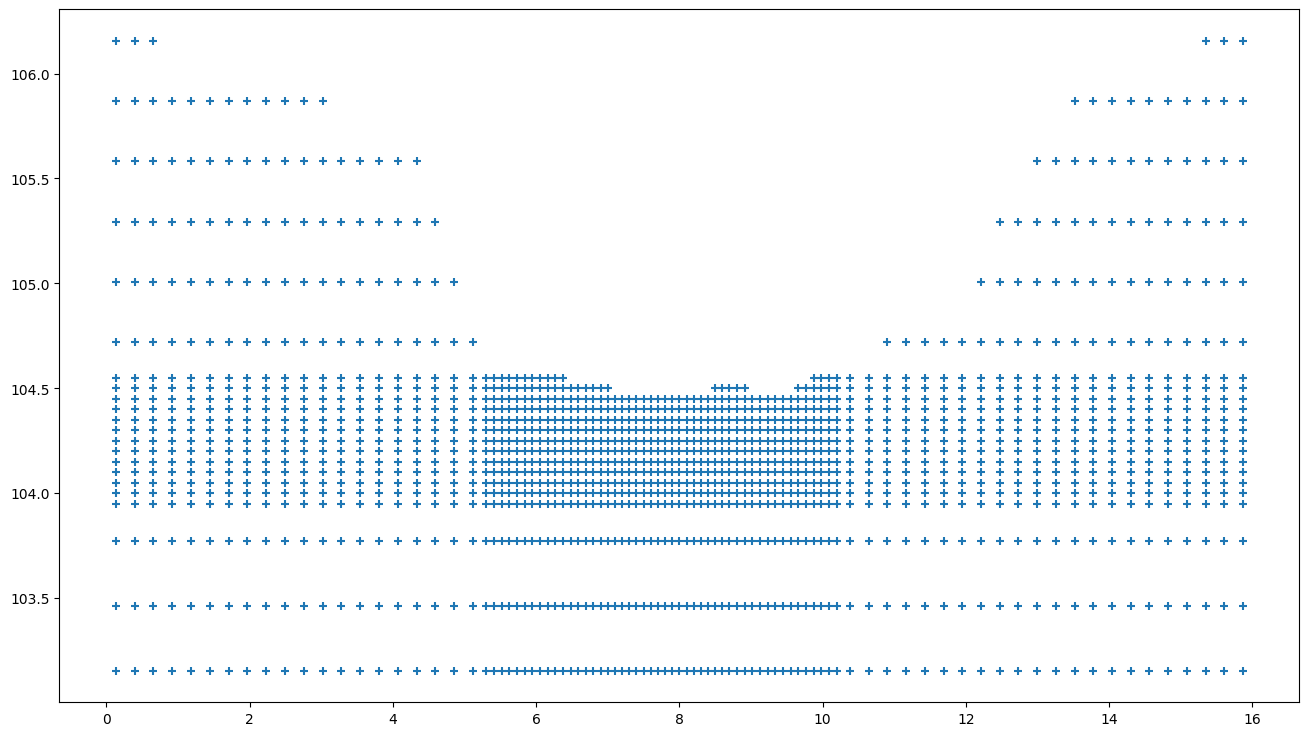

In [372]:
# interactive corrdinates on the plot
x = centres['x']
z = centres['z']
fig, ax = plt.subplots(figsize = (16,9))

ax.scatter(x,z,marker="+") # Trace le centre de chaque mailles
plt.show()

### Index = nmaille ginette to save

In [373]:

# find index of the centre near the pt100_coord and add the number of centre in pt100_coord
for i in range(len(pt100_coord)):
    # find the index of the centre nearest to pt100_coord
    index = ((centres['x'] - pt100_coord["x"][i])**2 + (centres['z'] - pt100_coord["z"][i])**2).idxmin()
    # add the index to the pt100_coord
    pt100_coord.loc[i, 'index'] = centres.loc[index, 'index']
    # add the distance to the pt100_coord
    pt100_coord.loc[i, 'distance'] = np.sqrt((centres['x'][index] - pt100_coord["x"][i])**2 + (centres['z'][index] - pt100_coord["z"][i])**2)
    pt100_coord.loc[i, 'xmaille'] = centres.loc[index, 'x']
    pt100_coord.loc[i, 'zmaille'] = centres.loc[index, 'z']


pt100_coord['n_maille'] = pt100_coord['index'].astype(int)


print(pt100_coord.head(8))

    hobo  pt100    x       z  index  distance  xmaille  zmaille  n_maille
0  hobo7      1  6.8  104.50  631.0       0.0      6.8   104.50       631
1  hobo7      2  6.8  104.35  634.0       0.0      6.8   104.35       634
2  hobo7      3  6.8  104.20  637.0       0.0      6.8   104.20       637
3  hobo7      4  6.8  104.05  640.0       0.0      6.8   104.05       640
4  hobo6      1  8.7  104.50  902.0       0.0      8.7   104.50       902
5  hobo6      2  8.7  104.35  905.0       0.0      8.7   104.35       905
6  hobo6      3  8.7  104.20  908.0       0.0      8.7   104.20       908
7  hobo6      4  8.7  104.05  911.0       0.0      8.7   104.05       911


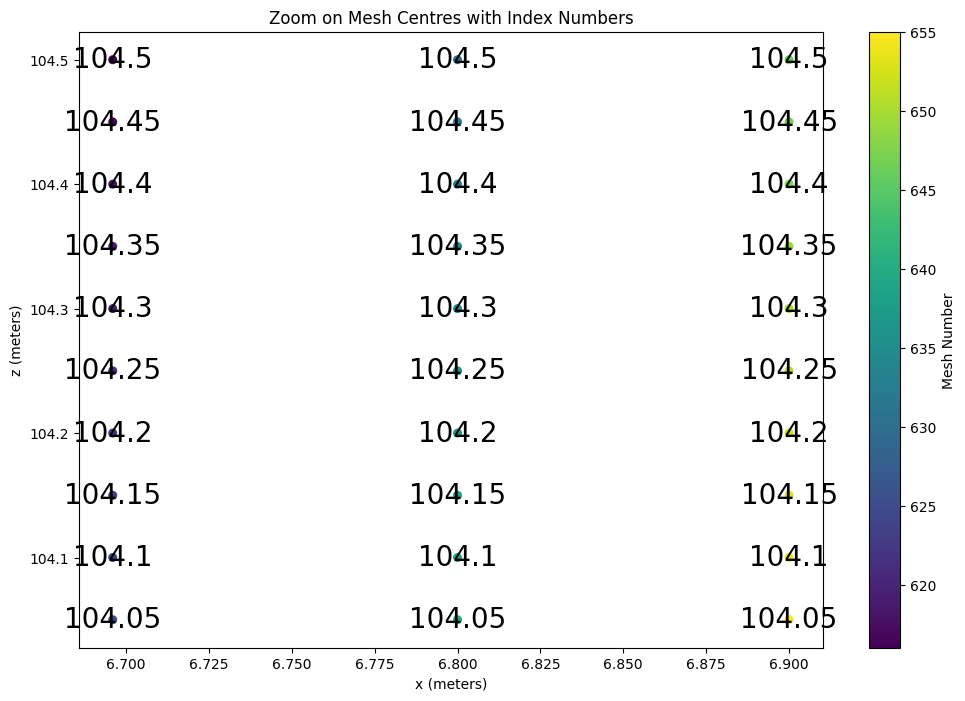

In [374]:

# Filter to zoom in on the desired region
centres_zoom = centres[
    (centres['x'] > 6.6) & (centres['x'] < 7) &
    (centres['z'] > 104.) & (centres['z'] < 104.6)
]

# Plot the points
plt.figure(figsize=(12, 8))
plt.scatter(centres_zoom['x'], centres_zoom['z'], c=centres_zoom['index'], cmap='viridis', s=30)

# Add text labels for each point
for _, row in centres_zoom.iterrows():
    plt.text(row['x'], row['z'], str(row['z']), fontsize=20, color='black', ha='center', va='center')

# Add axis labels and a colorbar for clarity
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.title('Zoom on Mesh Centres with Index Numbers')
plt.colorbar(label='Mesh Number')
plt.show()

# creation dimension

In [375]:

# Call the function coord_to_row_column
nb_col,nb_row=coord_to_row_column(script_dir)

Found 22 distinct columns; max assigned column = 22
Found 90 distinct rows;    max assigned row    = 90


In [376]:
importlib.reload(mesh_generator)
desc_maille=compute_am_bm_from_row_col(script_dir)

len(x_u) (unique x’s): 90
max row index  (from file): 90
len(z_u) (unique z’s): 22
max col index  (from file): 22
Wrote 1550 lines to /home/ariviere/Programmes/ginette/application/RIV2D/E_def_maille.dat


# Tableau de voisinage

In [377]:
importlib.reload(mesh_generator)
ivois = voisin_mesh(script_dir)
RG, RD = maille_limite(script_dir)

Neighbors saved to E_voisins.dat.


## test voisinage

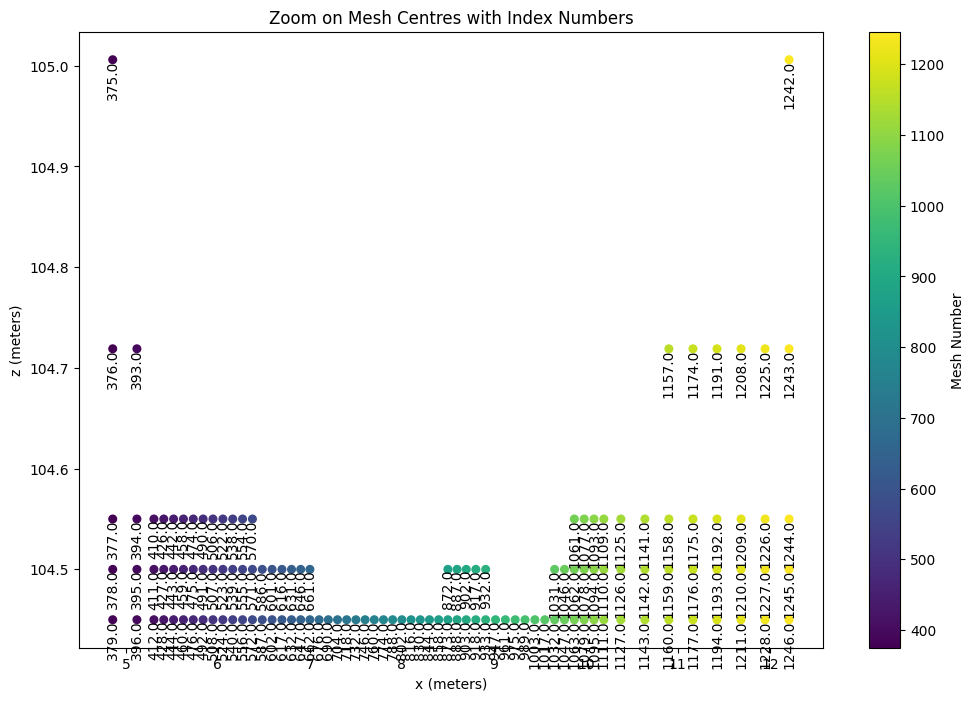

In [378]:


# Filter to zoom in on the desired region
centres_zoom = centres[
    (centres['x'] > 4.6) & (centres['x'] < 12.4) &
    (centres['z'] > 104.4) & (centres['z'] < 106)
]

# Plot the points
plt.figure(figsize=(12, 8))
plt.scatter(centres_zoom['x'], centres_zoom['z'], c=centres_zoom['index'], cmap='viridis', s=30)

# Add text labels for each point with rotated text
for _, row in centres_zoom.iterrows():
    plt.text(row['x'], row['z'], str(row['index']), fontsize=10, color='black', ha='center', va='top', 
             rotation=90)



# Add axis labels and a colorbar for clarity
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.title('Zoom on Mesh Centres with Index Numbers')
plt.colorbar(label='Mesh Number')
plt.show()


# creation des E_zone.dat
* E_zone.dat: numero zone de chaque maille 1 ligne = 1 interger
    '''
    Fonction qui permet de remplir le fichier E_zone.dat utile pour ginette. On a besoin pour cela du maillage (fichier E_coordonee.dat) et d'un dataframe comprenant
    les polygones rangés selon leur zone respectivent. La fonction test si le centre de chaque maille se trouve ou non dans un polygone. Une fois la zone de la maille
    trouvé c'est ajouté à une liste qui en fin de fonction sera écrit dans le fichier E_zone.dat

    Entrée
    path_E_coor (str) : Chemin (relatif ou absolu) amenant au fichier E_coordonee.dat
    path_E_zone (str) : Chemin (relatif ou absolu) amenant au fichier E_zone.dat
    polygons_by_zone (DataFrame) : Df comprenant les polygones qui définissent les différentes zones du maillage. Un exemple de création de polygons_by_zone est donné dans la suite du code
    default_zone (int) : zone (par default = 1) que l'on va attribuer au point contenu dans aucun polygone (Evite de définir tout les polygone dans polygons_by_zone)
    '''

In [379]:
# Correct zone definitions
# Be careful with the order of the polygons in the dictionary
polygons_by_zone = {
    5: [Polygon(poly_5)],  # Zone 5
    4: [Polygon(poly_4)],  # Zone 4
    2: [Polygon(rect_2)],  # Zone 2
    3: [Polygon(rect_3)]  # Zone 3

}

# Call the function to create the E_zone.dat file
creation_E_zone(script_dir, polygons_by_zone, default_zone=1)


### add verif

# Récuppérer les numéros des centres des PT100 pour les indiquer dans E_parametres.dat

In [380]:
print(nb_mesh)
# E_zone.dat with the number 1 for each mesh 
# need to be adapted with the nnumber of zone
# dataframe with integer 1 for each mesh
zone = pd.DataFrame(np.ones((nb_mesh, 1), dtype=int), columns=['zone'])
# print E_zone.dat 
zone.to_csv(os.path.join(mesh_dir, "E_zone.dat"), sep=' ', header=False, index=False)

1550


# creation des conditions aux limites


Faire tourner un régime permanant pour générer les conditions initiales

In [381]:
from src.src_python.Read_obs import process_obs_RIV2D
importlib.reload(Read_obs)

<module 'src.src_python.Read_obs' from '/home/ariviere/Programmes/ginette/src/src_python/Read_obs.py'>

In [ ]:

date_simul_bg = pd.to_datetime("2016/07/12 12:00:00")
nb_day = 1
desc_station = {'RD': 'pzps8', 'RG': "PZ1", 'RIV': "rivgil"}
all_data=process_obs_RIV2D(Station, obs_dir, date_simul_bg, nb_day, desc_station, pt100_coord)

all_data.head(10)

Processing sensor type: PZ1
Processing sensor type: Hobo6


/home/ariviere/Programmes/ginette/src/src_python/Read_obs.py:103: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_column] = pd.to_datetime(df[date_column], errors='raise')


Processing sensor type: pzps8
Processing sensor type: Hobo7


/home/ariviere/Programmes/ginette/src/src_python/Read_obs.py:103: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_column] = pd.to_datetime(df[date_column], errors='raise')


Processing sensor type: rivgil


/home/ariviere/Programmes/ginette/src/src_python/Read_obs.py:103: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_column] = pd.to_datetime(df[date_column], errors='raise')


,dates,H_PZ1,Temp_PZ1,Temp_5,Temp_6,Temp_7,Temp_8,H_RD,T_RD,Temp_1,Temp_2,Temp_3,Temp_4,H_RIV,T_RIV
0,2016-07-12 12:00:00,104.710,10.927,15.139,14.973,NaN,14.613,104.69300,13.227,14.819,15.137,15.033,14.685,104.77200,15.177
1,2016-07-12 12:15:00,104.710,10.927,15.160,14.966,NaN,14.610,104.69091,13.227,14.834,15.129,15.025,14.682,104.77108,15.257
2,2016-07-12 12:30:00,104.710,10.927,15.185,14.960,NaN,14.607,104.69058,13.227,14.853,15.123,15.019,14.679,104.77550,15.297
3,2016-07-12 12:45:00,104.710,10.927,15.209,14.954,NaN,14.605,104.68450,13.227,14.876,15.116,15.012,14.676,104.77283,15.190
4,2016-07-12 13:00:00,104.709,10.927,15.227,14.949,NaN,14.602,104.67808,13.227,14.891,15.111,15.006,14.673,104.77050,15.090
5,2016-07-12 13:15:00,104.709,10.927,15.233,14.945,NaN,14.599,104.67833,13.227,14.898,15.107,15.000,14.668,104.77233,15.230
6,2016-07-12 13:30:00,104.709,10.927,15.242,14.942,NaN,14.596,104.67600,13.233,14.906,15.104,14.992,14.665,104.77258,15.123
7,2016-07-12 13:45:00,104.709,10.927,15.246,14.940,NaN,14.595,104.67625,13.233,14.912,15.101,14.988,14.662,104.77258,15.090
8,2016-07-12 14:00:00,104.708,10.927,15.248,14.937,NaN,14.592,104.67258,13.233,14.913,15.098,14.982,14.658,104.77292,15.150
9,2016-07-12 14:15:00,104.708,10.927,15.249,14.936,NaN,14.589,104.67083,13.233,14.916,15.096,14.976,14.655,104.77383,15.223


In [399]:
dt=900
importlib.reload(Direct_model)
boundary_conditions_2D(all_data,dt)

KeyError: "None of [Index(['H_RG'], dtype='object')] are in the [columns]"

# id river

In [ ]:
importlib.reload(mesh_generator)
# Call the function to get the river mesh indices

hmax=all_data['H_RIV'].max()
hmin=all_data['H_RIV'].mean()
hqt90=all_data['H_RIV'].quantile(0.95)
print('hmax',hmax,'hmean',hmin,hqt90)
xRG=4.6
xRD=12.4
river=id_mesh_river(script_dir,hmax,hmin,xRG,xRD)
id_river_min,id_river_max=river

hmax 106.47683 hmean 104.7893882800853 105.05867


# verif id river

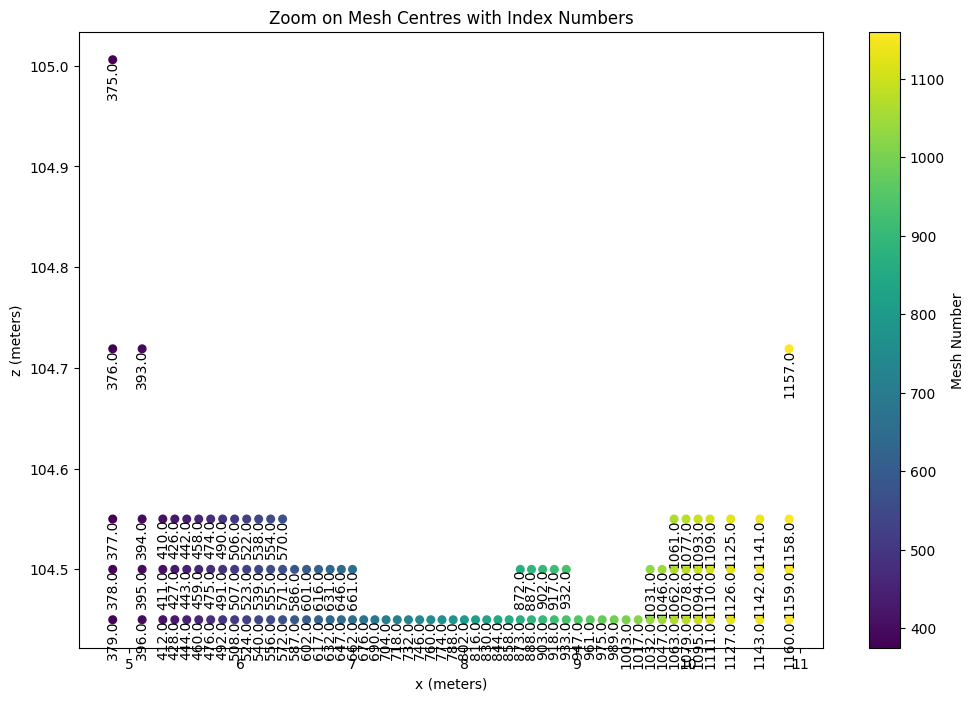

In [ ]:


# Filter to zoom in on the desired region
centres_zoom = centres[
    (centres['x'] > 4.8) & (centres['x'] < 11.1) &
    (centres['z'] > 104.4) & (centres['z'] < 106)
]

# Plot the points
plt.figure(figsize=(12, 8))
plt.scatter(centres_zoom['x'], centres_zoom['z'], c=centres_zoom['index'], cmap='viridis', s=30)

# Add text labels for each point with rotated text
for _, row in centres_zoom.iterrows():
    plt.text(row['x'], row['z'], str(row['index']), fontsize=10, color='black', ha='center', va='top', 
             rotation=90)



# Add axis labels and a colorbar for clarity
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.title('Zoom on Mesh Centres with Index Numbers')
plt.colorbar(label='Mesh Number')
plt.show()

In [ ]:
from src.src_python.Direct_model import zone_parameters_undef
importlib.reload(Direct_model)
parameters=['k', 'n', 'l', 'cs', 'r']
nb_zone=5
zone_parameters_undef(nb_zone, parameters)

In [ ]:
# definition des zones zones
#zone 1 
permeabilite_1=  3.543000000000000e-08
conductivite_1  = 5.675089730000000
porosity_1 = 0.06801300000000000
#zone 2
permeabilite_2 = 9.023200000000000e-06
conductivite_2= 5.999819400000000
porosity_2= 0.09017400000000000

# zone 3
permeabilite_3 =  1.419000000000000e-06
conductivite_3 = 5.999819400000000
porosity_3 =   0.06879000000000000

# zone 4
permeabilite_4=0.0001200000000000000
conductivite_4 = 1.000000000000000
porosity_4  =    0.01031000000000000 

# zone 5        
permeabilite_5=1.3599999999999999E-06  
conductivite_5=3.398790000000000
porosity_5 = 0.4000000000000000 

capacite_aquifere  =   2.5e+6 #cpm

# Heat capacity is calculated  by the following relationship
#  c_pm= c_w r_w n  * sat+ c_s r (1-n) + c_a r_a n * (1-sat)
# density
# c_s solid specific heat capacity = capacite calorifique massique du solide
#val_c= c_s m2/s2/C I advice to let this value constant.
# There are no way to calibrate the both parameter rho and c in the same time.
c_w=4185  #D+00	       m2/s2/C
r_w=1000  #kg/m3
# solid density r=val_r

# in ginette we need c_s and r
density=850 # r
c_s=(capacite_aquifere-c_w*r_w*porosity_5)/((1-porosity_5)*density)
print('c_s',c_s)


  
#         alanda_aquifer(eau+solide) = (alanda_w*n) + alandas*(1 -n))
#          alandae=0598E-03


       
   
 


  


c_s 1619.6078431372548


# transformer les paramètres pour être lisible

In [ ]:
# all perameabilities change in m2 and just the log
# loop nb_zone
for i in range(1, nb_zone + 1):
    # transform the permeability in m2 
    # name permeabilite_1 to permeabilite_5
    # get the name of the variable
    var_name = f"permeabilite_{i}"
    # get the value of the variable
    value = locals()[var_name]
    # transform the value in m2
    value = value * 1e-7
    # transform the value in log10
    value = np.log10(value)
    # set the value in the variable
    locals()[var_name] = value

    # print the value
    print(f"{var_name} = {locals()[var_name]}")


permeabilite_1 = -14.450628847666822
permeabilite_2 = -12.044639416351307
permeabilite_3 = -12.848017604542527
permeabilite_4 = -10.920818753952375
permeabilite_5 = -12.866461091629782


In [ ]:
#dataframe name column with parameters
value_zone_parameter=pd.DataFrame(columns=parameters)
value_zone_parameter['k'] = [permeabilite_1, permeabilite_2, permeabilite_3, permeabilite_4, permeabilite_5]
value_zone_parameter['n'] = [porosity_1, porosity_2, porosity_3, porosity_4, porosity_5]
value_zone_parameter['l'] = [conductivite_1,conductivite_2,conductivite_3,conductivite_4,conductivite_5]
value_zone_parameter['cs'] = [c_s, c_s, c_s, c_s, c_s]
value_zone_parameter['r'] = [density, density, density, density, density]
value_zone_parameter.head()



,k,n,l,cs,r
0,-14.450629,0.068013,5.675090,1619.607843,850
1,-12.044639,0.090174,5.999819,1619.607843,850
2,-12.848018,0.068790,5.999819,1619.607843,850
3,-10.920819,0.010310,1.000000,1619.607843,850
4,-12.866461,0.400000,3.398790,1619.607843,850


In [ ]:
from src.src_python.Direct_model import generate_zone_parameters_undef
importlib.reload(Direct_model)


generate_zone_parameters_undef(nb_zone,value_zone_parameter=value_zone_parameter)

# Premiere simulation calculer le temps de simulation

Grid search avec seulement la permeabilté de la zone 4 et 5 au début.
Ploter pour les 8 capteurs de températures les rmse

Ensuite grid search sur k, porosité et conductivité thermique.

Tester sur une autre periode contrasté.

In [ ]:
pt100_coord.head(10)


,hobo,pt100,x,z,index,distance,xmaille,zmaille,n_maille
0,hobo7,1,6.8,104.50,1,0.0,6.8,104.50,631
1,hobo7,2,6.8,104.35,2,0.0,6.8,104.35,634
2,hobo7,3,6.8,104.20,3,0.0,6.8,104.20,637
3,hobo7,4,6.8,104.05,4,0.0,6.8,104.05,640
4,hobo6,1,8.7,104.50,5,0.0,8.7,104.50,902
5,hobo6,2,8.7,104.35,6,0.0,8.7,104.35,905
6,hobo6,3,8.7,104.20,7,0.0,8.7,104.20,908
7,hobo6,4,8.7,104.05,8,0.0,8.7,104.05,911


In [ ]:
importlib.reload(Direct_model)
setup_ginette_perm_2D(pt100_coord,nb_mesh,nb_col,nb_row)


    hobo  pt100    x       z  index  distance  xmaille  zmaille  n_maille
0  hobo7      1  6.8  104.50      1       0.0      6.8   104.50       631
1  hobo7      2  6.8  104.35      2       0.0      6.8   104.35       634
2  hobo7      3  6.8  104.20      3       0.0      6.8   104.20       637
3  hobo7      4  6.8  104.05      4       0.0      6.8   104.05       640
4  hobo6      1  8.7  104.50      5       0.0      8.7   104.50       902


In [ ]:
initial_conditions_perm_2D()

In [ ]:
importlib.reload(Direct_model)
from src.src_python.Direct_model import run_direct_model_2D
run_direct_model_2D()

At line 786 of file ../../src/ginette_V2.f90 (unit = 228, file = 'E_chargeT_RG.dat')
Fortran runtime error: Bad real number in item 1 of list input

Error termination. Backtrace:
#0  0x146dea423960 in ???
#1  0x146dea4244d9 in ???
#2  0x146dea42510f in ???
#3  0x146dea6701b6 in ???
#4  0x146dea6715fd in ???
#5  0x146dea6722aa in ???
#6  0x61da3e77d7dc in ???
#7  0x61da3e7ba0b7 in ???
#8  0x146dea029d8f in __libc_start_call_main
	at ../sysdeps/nptl/libc_start_call_main.h:58
#9  0x146dea029e3f in __libc_start_main_impl
	at ../csu/libc-start.c:392
#10  0x61da3e754254 in ???
#11  0xffffffffffffffff in ???
